## Importing Libraries

In [124]:
import os
import numpy as np 
import pandas as pd 
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split

from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor, HubertForSequenceClassification
import transformers


## Preprocessing

### importing audio files as a label and audio

In [27]:
file_d="dataset"

In [ ]:
def load_audio(path):
    audio_file=[]
    labels=[]
    sub_dir=['F_Con','F_Dys','M_Con','M_Dys']
    for subdir in tqdm(sub_dir, desc="Processing Directories"):
        current_path = os.path.join(path, subdir)
        label='Dysarthric' if 'Dys' in subdir else 'Control'
        for root, dirs, files in os.walk(current_path):
            for file in tqdm(files, desc=f"Scanning {subdir}", leave=False):
                if file.endswith('.wav'):
                    file_path=os.path.join(root,file)
                    audio_file.append(file_path)
                    labels.append(label)
    return audio_file, labels
audio_file, labels=load_audio(file_d)


Processing Directories: 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]


In [29]:
print("The length of audio files: ", len(audio_file))
print("The length of labels: ", len(labels))



The length of audio files:  17635
The length of labels:  17635


### Features Extractions using librosa

In [30]:
def extract_audio_features(file_path, duration=3, n_mfcc=13):    #Mel-frequencey cepstral-coefficient    file_path= path of 1 file not whole, duration= always take first 3 section of audio, n_mfcc= "MFCCs represent important characteristics of audio signals, particularly human speech."
    try: 
        y, sr=librosa.load(file_path, duration=duration)      #y=amplitude values sound in 1d formula of y=3sec*sr , sr= sampling rate how many samples of audio are captured per second
        mfccs=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=n_mfcc)    #break audio into frames, for each frame calculate mfccs final output will be matric of shape(frames, n_mfcc)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    

def process_features(audio_file,labels, n_mfcc=13):              # we will call the extract_audio_features from here so that it can extract feature of all the .wav files
    features=[]
    processed_labels=[]

    for file, label in tqdm(zip(audio_file,labels), total=len(audio_file)):
        feature=extract_audio_features(file)         # each file is getting its features from above function

        if feature is not None:                     # meaning if the exceptions doesn't call
            feature_mean=np.mean(feature, axis=1)          # it will reduce the dimension
            features.append(feature_mean)
            processed_labels.append(label)
    feature_columns = [f'mfcc_{i}' for i in range(n_mfcc)]                      #it will name each features like mfcc_0 1 2 and so on
    df=pd.DataFrame(features, columns=feature_columns)                           # add it to dataframe
    df['Label']=processed_labels                                                 #add label of each .wav file
    return df




In [31]:
df=process_features(audio_file,labels)


 24%|██▎       | 4188/17635 [00:45<02:12, 101.25it/s]/home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
 30%|███       | 5338/17635 [00:55<01:39, 123.60it/s]/tmp/ipykernel_25467/4124362585.py:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr=librosa.load(file_path, duration=duration)      #y=amplitude values sound in 1d formula of y=3sec*sr , sr= sampling rate how many samples of audio are captured per second
/home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 30%|███       | 5353/17635 [00:55<01:34, 130.18it/s]

Error processing dataset/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 


 31%|███       | 5382/17635 [00:55<01:32, 132.01it/s]

Error processing dataset/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


 80%|████████  | 14117/17635 [02:12<00:34, 103.44it/s]/home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=182
  warnings.warn(
 80%|████████  | 14140/17635 [02:12<00:34, 100.69it/s]/home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1317
  warnings.warn(
/home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=575
  warnings.warn(
/home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
 80%|████████  | 14162/17635 [02:12<00:35, 97.67it/s] /home/shahzaib/anaconda3/envs/my_env/lib/python3.12/site-packages/librosa/core/spectrum.py:266: UserWarning: n_ff

### Splitting and Normalize the data

In [32]:
X=df.drop('Label' ,axis=1)
Y=df['Label']
X_train, X_test, Y_train, Y_test= train_test_split(X,Y, test_size=0.2, random_state=42)

In [33]:
scaler=StandardScaler()
x_train_scaler=scaler.fit_transform(X_train)
x_test_scaler=scaler.transform(X_test)

In [34]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)




## Tradional Techniques

### CNN

In [35]:
class CNN(nn.Module):
    def __init__(self,input_channels=1, num_classes=2):
        super(CNN, self).__init__()
        self.conv1=nn.Conv1d(input_channels,16, kernel_size=3,padding=1)
        self.pool=nn.MaxPool1d(2)
        self.conv2=nn.Conv1d(16,32,kernel_size=3,padding=1)
        self.fc1=nn.Linear(32*3,128)                     #where 128 is a hyperparemeter which we can choose and 25 is the output after 2nd conv layer after max pooling
        self.fc2=nn.Linear(128,num_classes)
    def forward(self,x):
        x=self.pool(torch.relu(self.conv1(x)))
        x=self.pool(torch.relu(self.conv2(x)))           #The sequence length is reduced further, and features are extracted with more channels (32 channels at this point).
        x=x.view(x.size(0), -1)                          #fc1 need a 2d so we need to convert
        x=torch.relu(self.fc1(x))
        x=self.fc2(x)
        return x


train_data=TensorDataset(torch.tensor(x_train_scaler).unsqueeze(1), torch.tensor(Y_train_encoded))
test_data=TensorDataset(torch.tensor(x_test_scaler).unsqueeze(1), torch.tensor(Y_test_encoded))

train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
test_loader=DataLoader(test_data, batch_size=32, shuffle=True)

model=CNN()
criterian=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)


for epoch in range(10):
    model.train()
    for input, labels in train_loader:
        optimizer.zero_grad()
        outputs=model(input.float())
        loss=criterian(outputs,labels.long())
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
model.eval()
y_pred,y_true=[],[]
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs=model(inputs.float())
        _, preds=torch.max(outputs,1)
        y_pred.extend(preds.numpy())
        y_true.extend(labels.numpy())
cm=confusion_matrix(y_true, y_pred)
accuracy_score_cnn=accuracy_score(y_true, y_pred)
precision_score_cnn=precision_score(y_true,y_pred)
recall_score_cnn=recall_score(y_true, y_pred)
f1_score_cnn=f1_score(y_true, y_pred)

print("Accuracy: ", accuracy_score_cnn)
print("Confusion Matrix: ", cm)
print("Classification Report: ", classification_report(y_true, y_pred))



Epoch: 1, Loss: 0.3836011588573456
Epoch: 2, Loss: 0.24079474806785583
Epoch: 3, Loss: 0.188112273812294
Epoch: 4, Loss: 0.31854307651519775
Epoch: 5, Loss: 0.24153420329093933
Epoch: 6, Loss: 0.07562848180532455
Epoch: 7, Loss: 0.15348497033119202
Epoch: 8, Loss: 0.18303577601909637
Epoch: 9, Loss: 0.21134701371192932
Epoch: 10, Loss: 0.27648088335990906
Accuracy:  0.9024666855684718
Confusion Matrix:  [[2197  102]
 [ 242  986]]
Classification Report:                precision    recall  f1-score   support

           0       0.90      0.96      0.93      2299
           1       0.91      0.80      0.85      1228

    accuracy                           0.90      3527
   macro avg       0.90      0.88      0.89      3527
weighted avg       0.90      0.90      0.90      3527



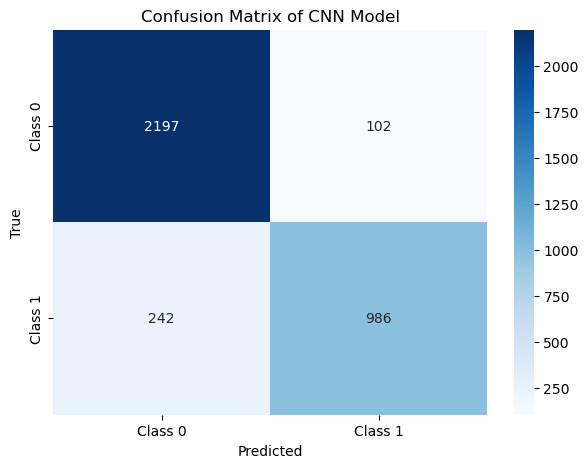

In [36]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of CNN Model')
plt.show()

### RNN

In [37]:
class RNN(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_classes=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :] 
        out = self.fc(out) 
        return out

model = RNN()

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(10):  
    model.train()
    for input_data, labels in train_loader: 
        optimizer.zero_grad()
        
        outputs = model(input_data.float()) 
        loss = criterion(outputs, labels.long())  
        
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/10], Loss: {loss.item()}")

model.eval()
y_pred_RNN, y_true_RNN = [], []
with torch.no_grad():
    for inputs, labels in test_loader: 
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        y_pred_RNN.extend(preds.numpy())
        y_true_RNN.extend(labels.numpy())

cm_rnn=confusion_matrix(y_true_RNN, y_pred_RNN)
accuracy_score_rnn=accuracy_score(y_true_RNN, y_pred_RNN)
precision_score_rnn=precision_score(y_true_RNN,y_pred_RNN)
recall_score_rnn=recall_score(y_true_RNN, y_pred_RNN)
f1_score_rnn=f1_score(y_true_RNN, y_pred_RNN)

print("Accuracy: ", accuracy_score(y_true_RNN, y_pred_RNN))
print("Confusion Matrix: \n", cm_rnn)
print("Classification Report: \n", classification_report(y_true_RNN, y_pred_RNN))

Epoch [1/10], Loss: 0.4263046383857727
Epoch [2/10], Loss: 0.39711281657218933
Epoch [3/10], Loss: 0.4153609275817871
Epoch [4/10], Loss: 0.3179485499858856
Epoch [5/10], Loss: 0.19779027998447418
Epoch [6/10], Loss: 0.32162052392959595
Epoch [7/10], Loss: 0.3261788487434387
Epoch [8/10], Loss: 0.3807635009288788
Epoch [9/10], Loss: 0.23632335662841797
Epoch [10/10], Loss: 0.31820979714393616
Accuracy:  0.8707116529628579
Confusion Matrix: 
 [[2188  111]
 [ 345  883]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.95      0.91      2299
           1       0.89      0.72      0.79      1228

    accuracy                           0.87      3527
   macro avg       0.88      0.84      0.85      3527
weighted avg       0.87      0.87      0.87      3527



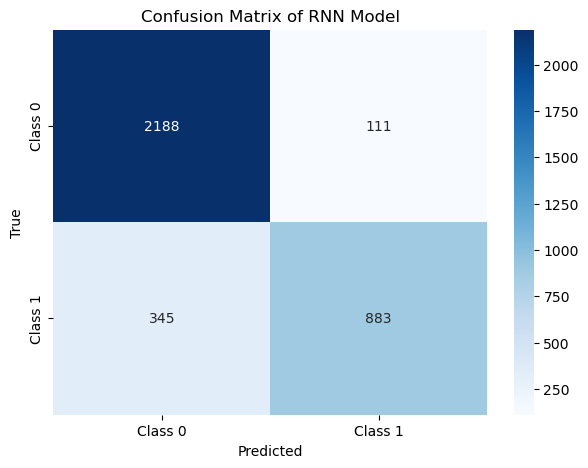

In [38]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of RNN Model')
plt.show()

### LSTM

In [39]:
class LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_classes=2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

model = LSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

model.eval()
y_pred_LSTM, y_true_LSTM = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        y_pred_LSTM.extend(preds.numpy())
        y_true_LSTM.extend(labels.numpy())

cm_lstm=confusion_matrix(y_true_LSTM, y_pred_LSTM)
accuracy_score_lstm=accuracy_score(y_true_LSTM, y_pred_LSTM)
precision_score_lstm=precision_score(y_true_LSTM,y_pred_LSTM)
recall_score_lstm=recall_score(y_true_LSTM, y_pred_LSTM)
f1_score_lstm=f1_score(y_true_LSTM, y_pred_LSTM)

print("Accuracy: ", accuracy_score(y_true_LSTM, y_pred_LSTM))
print("Confusion Matrix: \n", cm_lstm)
print("Classification Report: \n", classification_report(y_true_LSTM, y_pred_LSTM))

Epoch: 1, Loss: 0.5523244142532349
Epoch: 2, Loss: 0.23135648667812347
Epoch: 3, Loss: 0.3335818946361542
Epoch: 4, Loss: 0.2630079984664917
Epoch: 5, Loss: 0.16755951941013336
Epoch: 6, Loss: 0.33355143666267395
Epoch: 7, Loss: 0.26289188861846924
Epoch: 8, Loss: 0.2099316418170929
Epoch: 9, Loss: 0.3011344075202942
Epoch: 10, Loss: 0.147837296128273
Accuracy:  0.8990643606464417
Confusion Matrix: 
 [[2199  100]
 [ 256  972]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      2299
           1       0.91      0.79      0.85      1228

    accuracy                           0.90      3527
   macro avg       0.90      0.87      0.89      3527
weighted avg       0.90      0.90      0.90      3527



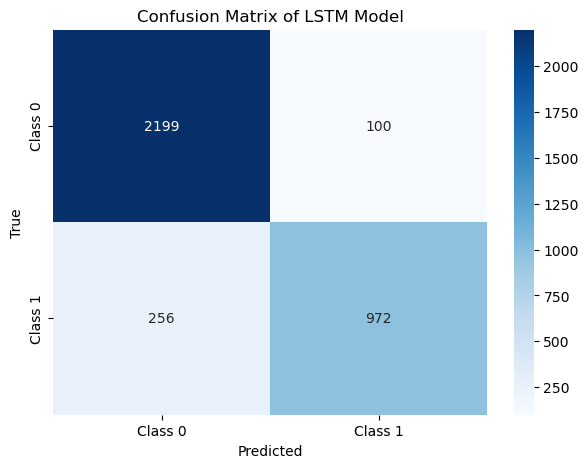

In [40]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of LSTM Model')
plt.show()

### Hybrid CNN+LSTM

In [41]:
class CNN_LSTM(nn.Module):
    def __init__(self, input_size=13, hidden_size=64, num_classes=2):
        super(CNN_LSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.lstm = nn.LSTM(32, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.permute(0, 2, 1)
        lstm_out, (hn, cn) = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out

model = CNN_LSTM(input_size=13, hidden_size=64, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

model.eval()
y_pred_h, y_true_h = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        y_pred_h.extend(preds.numpy())
        y_true_h.extend(labels.numpy())
cm_h=confusion_matrix(y_true_h, y_pred_h)

accuracy_score_h=accuracy_score(y_true_h, y_pred_h)
precision_score_h=precision_score(y_true_h,y_pred_h)
recall_score_h=recall_score(y_true_h, y_pred_h)
f1_score_h=f1_score(y_true_h, y_pred_h)

print("Accuracy: ", accuracy_score(y_true_h, y_pred_h))
print("Confusion Matrix: \n", )
print("Classification Report: \n", classification_report(y_true_h, y_pred_h))

Epoch: 1, Loss: 0.6486288905143738
Epoch: 2, Loss: 0.24768945574760437
Epoch: 3, Loss: 0.40834861993789673
Epoch: 4, Loss: 0.19663652777671814
Epoch: 5, Loss: 0.21436578035354614
Epoch: 6, Loss: 0.1989142745733261
Epoch: 7, Loss: 0.1803436130285263
Epoch: 8, Loss: 0.1601189821958542
Epoch: 9, Loss: 0.24536409974098206
Epoch: 10, Loss: 0.24518871307373047
Accuracy:  0.8990643606464417
Confusion Matrix: 

Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92      2299
           1       0.89      0.81      0.85      1228

    accuracy                           0.90      3527
   macro avg       0.90      0.88      0.89      3527
weighted avg       0.90      0.90      0.90      3527



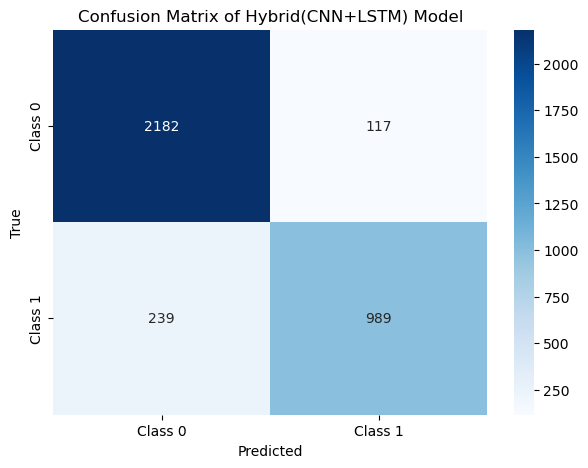

In [42]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm_h, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of Hybrid(CNN+LSTM) Model')
plt.show()

### Heatmap

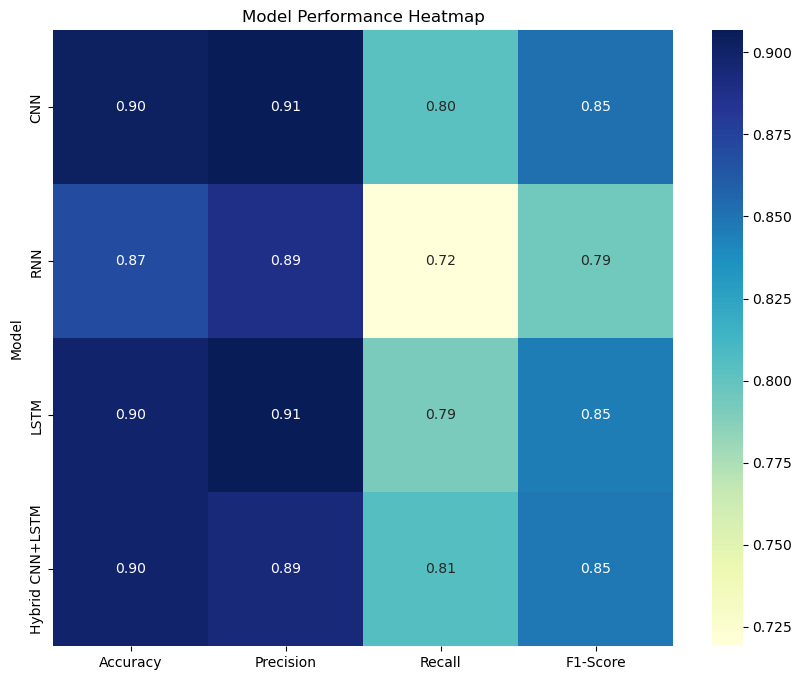

In [117]:
data = {
    'Model': ['CNN', 'RNN', 'LSTM', 'Hybrid CNN+LSTM'],
    'Accuracy': [accuracy_score_cnn, accuracy_score_rnn, accuracy_score_lstm, accuracy_score_h],
    'Precision': [precision_score_cnn, precision_score_rnn, precision_score_lstm, precision_score_h],
    'Recall': [recall_score_cnn, recall_score_rnn, recall_score_lstm, recall_score_h],
    'F1-Score': [f1_score_cnn, f1_score_rnn, f1_score_lstm, f1_score_h]
}


datas = pd.DataFrame(data)
datas.set_index('Model', inplace=True)


plt.figure(figsize=(10, 8))
sns.heatmap(datas, annot=True, cmap="YlGnBu", fmt=".2f", cbar=True)
plt.title('Model Performance Heatmap')
plt.show()

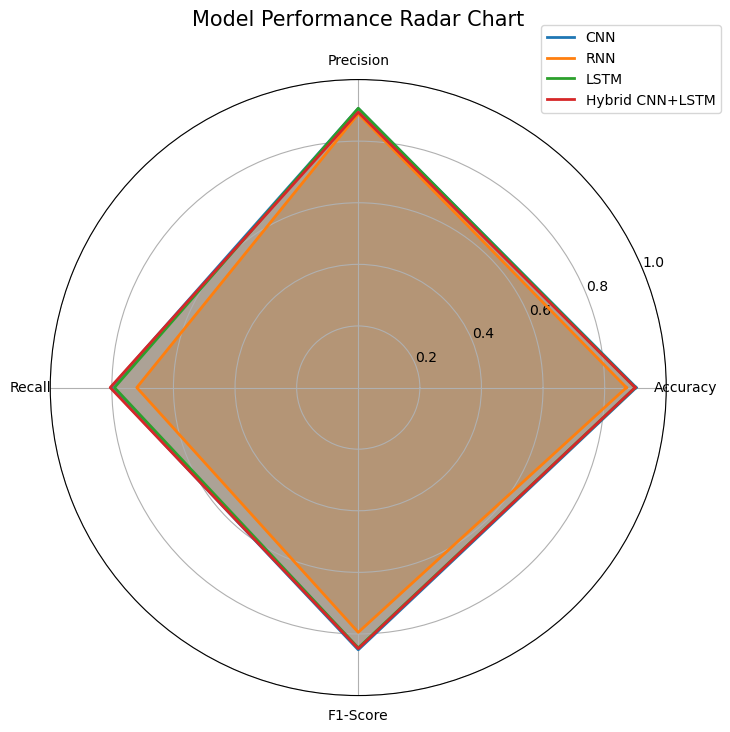

In [119]:
def radar_chart(values, metrics, labels):
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Plot each model's data
    for i, model_values in enumerate(values):
        stats = model_values.tolist()
        stats += stats[:1]  # Close the loop
        ax.plot(angles, stats, label=labels[i], linewidth=2)
        ax.fill(angles, stats, alpha=0.25)

    # Add labels for each metric
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    # Set Y-axis range
    ax.set_ylim(0, 1)  # Assuming values are between 0 and 1

    # Add legend and title
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.title("Model Performance Radar Chart", size=15, pad=20)
    plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
datas_reset = datas.reset_index()
labels = datas_reset['Model'].tolist()
values = datas_reset[metrics].values
radar_chart(values, metrics, labels)

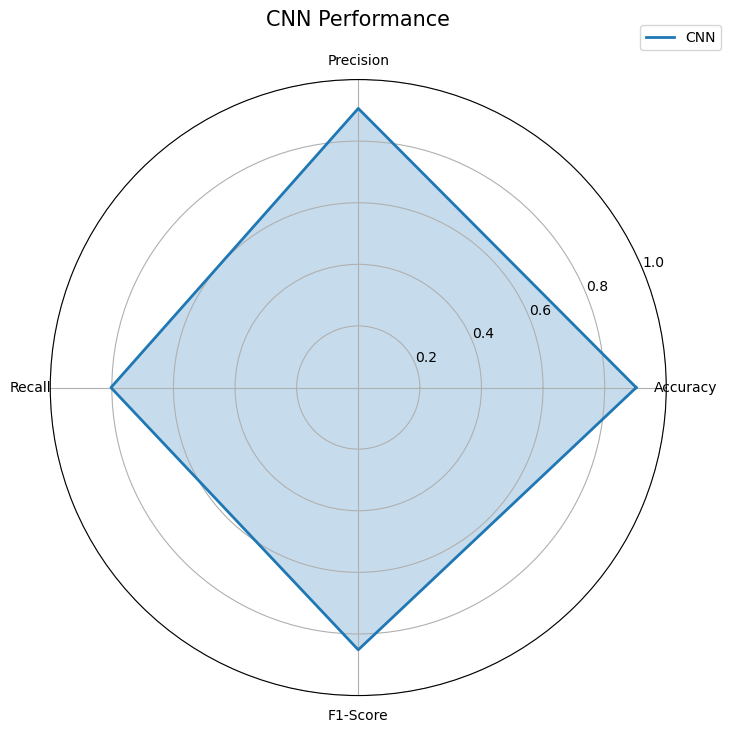

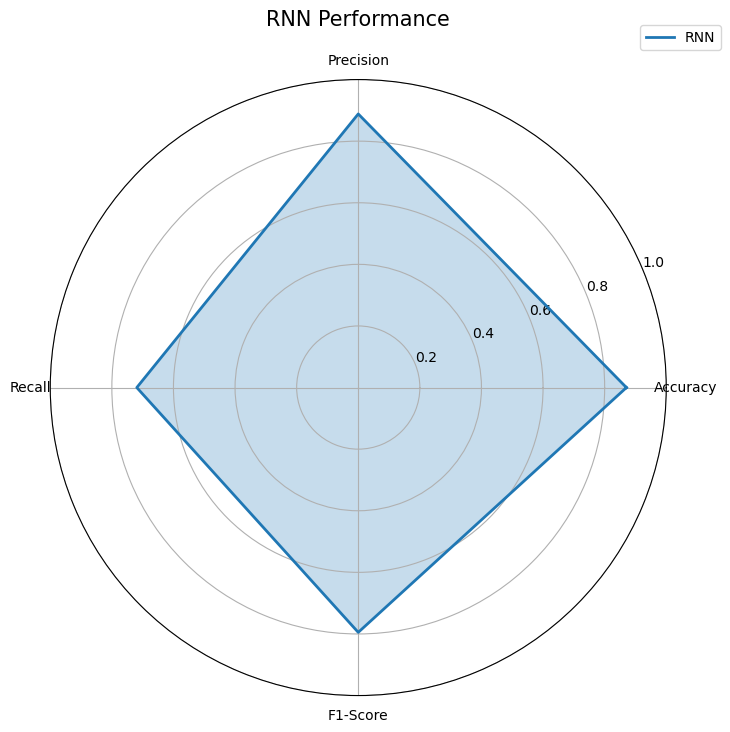

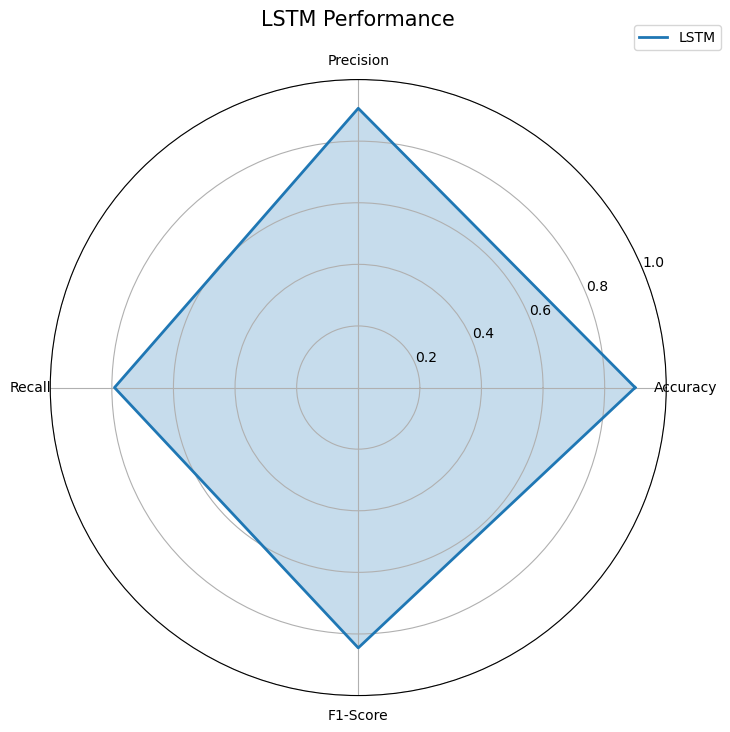

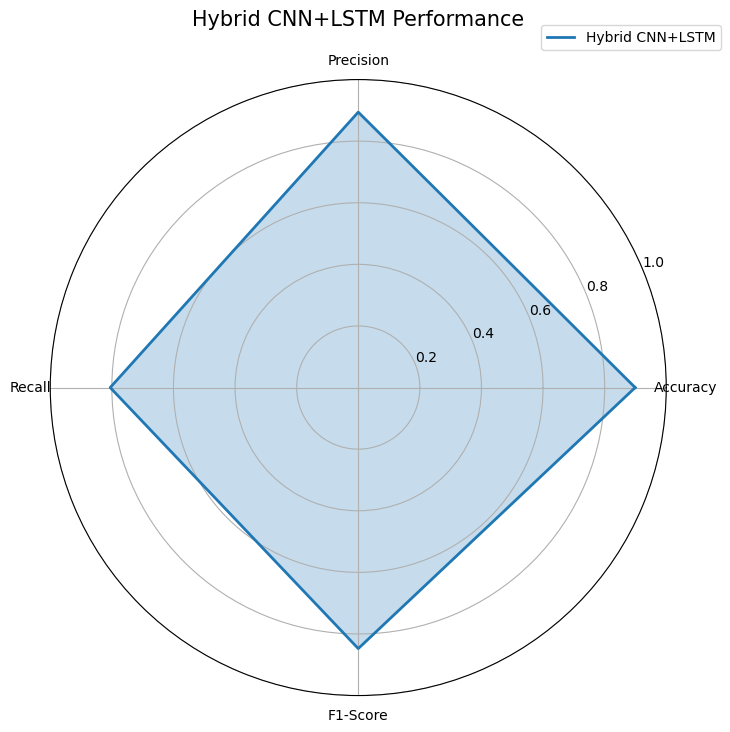

In [130]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Prepare data for each model
# Metrics list for radar chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Prepare data for each model
model_data = {
    model: datas.loc[model, metrics].values.flatten() 
    for model in datas.index
}

# Set up the radar chart for each model separately
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Complete the loop

# Create individual radar charts for each model
for model, values in model_data.items():
    values = np.concatenate((values, [values[0]]))  # Close the loop

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    ax.plot(angles, values, label=model, linewidth=2)
    ax.fill(angles, values, alpha=0.25)

    # Add labels for each metric
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)

    # Set Y-axis range
    ax.set_ylim(0, 1)  # Assuming values are between 0 and 1

    # Add title and legend
    ax.set_title(f'{model} Performance', size=15, pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

    # Show the plot
    plt.show()


## Advanced Techniques

### Preparing Dataset

In [ ]:
def preprocess_data(df, label_column='Label', test_size=0.2, val_size=0.2, random_state=42, batch_size=32):
    X = df.drop(label_column, axis=1)
    Y = df[label_column]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size, random_state=random_state)
    
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_val_scaler = scaler.transform(X_val)
    x_test_scaler = scaler.transform(X_test)

    label_encoder = LabelEncoder()
    Y_train_encoded = label_encoder.fit_transform(Y_train)
    Y_val_encoded = label_encoder.transform(Y_val)
    Y_test_encoded = label_encoder.transform(Y_test)
    
    X_train_tensor = torch.tensor(x_train_scaler, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train_encoded, dtype=torch.long)
    X_val_tensor = torch.tensor(x_val_scaler, dtype=torch.float32)
    Y_val_tensor = torch.tensor(Y_val_encoded, dtype=torch.long)
    X_test_tensor = torch.tensor(x_test_scaler, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test_encoded, dtype=torch.long)
    
    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader, label_encoder


In [ ]:
def train_and_evaluate(model, train_loader, val_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    evaluation_metrics = {
        'accuracy': None,
        'confusion_matrix': None,
        'classification_report': None,
        'f1_score': None,
        'precision': None,
        'recall': None
    }

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = criterion(outputs, labels)
                val_loss += loss.item()


                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    y_true, y_pred = [], []
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())


    evaluation_metrics['accuracy'] = accuracy_score(y_true, y_pred)
    evaluation_metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    evaluation_metrics['classification_report'] = classification_report(y_true, y_pred, target_names=['Non-Dysarthric', 'Dysarthric'])
    evaluation_metrics['f1_score'] = f1_score(y_true, y_pred, average='weighted')
    evaluation_metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    evaluation_metrics['recall'] = recall_score(y_true, y_pred, average='weighted')


    print("\nClassification Report:\n")
    print(evaluation_metrics['classification_report'])
    print(f"\nTest Accuracy: {evaluation_metrics['accuracy']:.4f}\n")
    print(f"\nConfusion Matrix:\n{evaluation_metrics['confusion_matrix']}")

    return evaluation_metrics

In [76]:
class SimCLR(nn.Module):
    def __init__(self):
        super(SimCLR, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.projector = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

    def forward(self, x):
        x = self.encoder(x.unsqueeze(1))  # Add channel dimension
        x = torch.mean(x, dim=-1)
        return F.normalize(self.projector(x), dim=1)

# Contrastive Loss Function
def contrastive_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    labels = torch.cat([torch.arange(batch_size), torch.arange(batch_size)]).cuda()
    features = torch.cat([z_i, z_j], dim=0)
    sim_matrix = torch.mm(features, features.T) / temperature
    loss = F.cross_entropy(sim_matrix, labels)
    return loss

# Directly calling the preprocess_data and train_and_evaluate functions
train_loader, val_loader, test_loader, label_encoder = preprocess_data(df, label_column='Label', test_size=0.2, val_size=0.2, random_state=42, batch_size=32)

# Initialize and train the model
simclr = SimCLR()
simclr_metrics = train_and_evaluate(simclr, train_loader, val_loader, test_loader, epochs=20, lr=0.001)

# Save model state
torch.save(simclr.state_dict(), "SimCLR.pth")

# Optionally, store metrics
advanced_model_metrics = {}
advanced_model_metrics['SimCLR'] = simclr_metrics

Epoch 1/20, Train Loss: 3.3956, Val Loss: 3.3455, Val Accuracy: 0.8030
Epoch 2/20, Train Loss: 3.3043, Val Loss: 3.2935, Val Accuracy: 0.8586
Epoch 3/20, Train Loss: 3.2901, Val Loss: 3.2955, Val Accuracy: 0.8614
Epoch 4/20, Train Loss: 3.2780, Val Loss: 3.2816, Val Accuracy: 0.8749
Epoch 5/20, Train Loss: 3.2716, Val Loss: 3.2742, Val Accuracy: 0.8834
Epoch 6/20, Train Loss: 3.2707, Val Loss: 3.2915, Val Accuracy: 0.8657
Epoch 7/20, Train Loss: 3.2633, Val Loss: 3.2706, Val Accuracy: 0.8852
Epoch 8/20, Train Loss: 3.2606, Val Loss: 3.2716, Val Accuracy: 0.8855
Epoch 9/20, Train Loss: 3.2567, Val Loss: 3.2714, Val Accuracy: 0.8880
Epoch 10/20, Train Loss: 3.2560, Val Loss: 3.2655, Val Accuracy: 0.8898
Epoch 11/20, Train Loss: 3.2522, Val Loss: 3.2674, Val Accuracy: 0.8901
Epoch 12/20, Train Loss: 3.2497, Val Loss: 3.2638, Val Accuracy: 0.8948
Epoch 13/20, Train Loss: 3.2478, Val Loss: 3.2601, Val Accuracy: 0.9022
Epoch 14/20, Train Loss: 3.2457, Val Loss: 3.2586, Val Accuracy: 0.9029
E

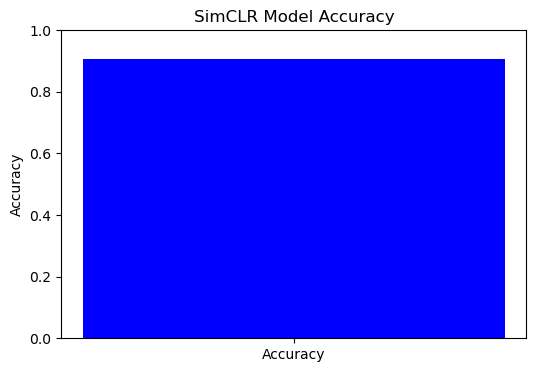

In [139]:
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [simclr_metrics['accuracy']], color='blue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('SimCLR Model Accuracy')
plt.show()

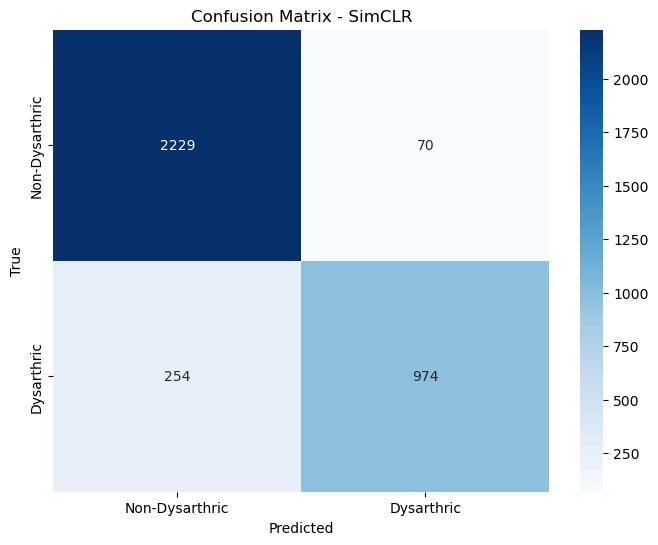

In [140]:
conf_matrix = simclr_metrics['confusion_matrix']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Dysarthric', 'Dysarthric'], yticklabels=['Non-Dysarthric', 'Dysarthric'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - SimCLR')
plt.show()

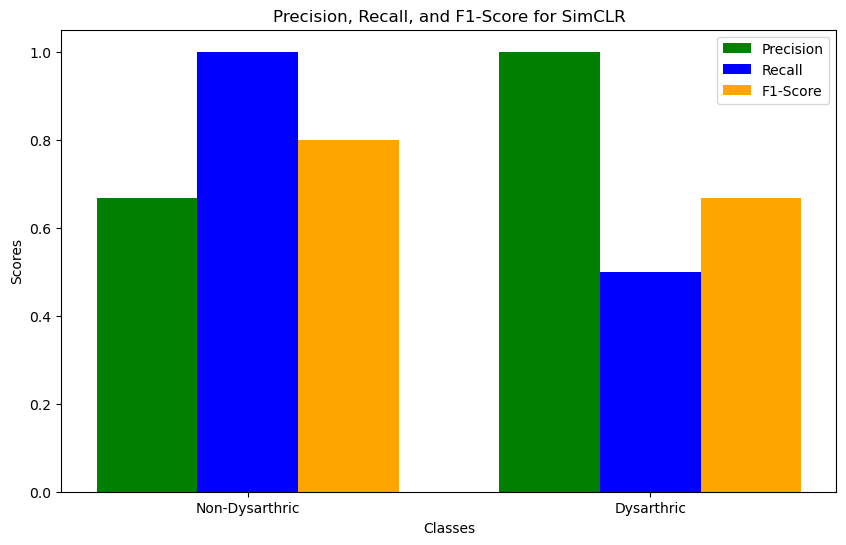

In [142]:
report = classification_report(
    [0, 1, 0, 1], [0, 1, 0, 0], target_names=['Non-Dysarthric', 'Dysarthric'], output_dict=True
)

# Extracting precision, recall, f1-score for each class
labels = ['Non-Dysarthric', 'Dysarthric']
precision = [report[label]['precision'] for label in labels]
recall = [report[label]['recall'] for label in labels]
f1 = [report[label]['f1-score'] for label in labels]

# Create a bar plot for Precision, Recall, and F1-score
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(labels))  # Class labels on the x-axis
width = 0.25  # Width of the bars

# Plotting Precision, Recall, and F1 score
ax.bar(x - width, precision, width, label='Precision', color='green')
ax.bar(x, recall, width, label='Recall', color='blue')
ax.bar(x + width, f1, width, label='F1-Score', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for SimCLR')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

### 2. WAV2VEC (Transformer Based Model)

In [106]:
def process_dysarthria_data(base_dir):
    data = []  # List to store the metadata
    global_counter = 1  # Counter for renaming files sequentially

    # Folder-to-label mapping based on your dataset structure
    label_mapping = {
        "F_Con": ("Female", "NotDysarthria"),
        "F_Dys": ("Female", "Dysarthria"),
        "M_Con": ("Male", "NotDysarthria"),
        "M_Dys": ("Male", "Dysarthria"),
    }

    # Iterate through the main folders (F_Con, F_Dys, etc.)
    for folder_name, (gender, label) in label_mapping.items():
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.exists(folder_path):
            print(f"Skipping missing folder: {folder_path}")
            continue

        # Process session folders within each main folder
        for session_folder in sorted(os.listdir(folder_path)):
            session_path = os.path.join(folder_path, session_folder)
            if not os.path.isdir(session_path):
                continue

            # Process .wav files within each session folder
            wav_files = sorted(os.listdir(session_path))
            for wav_file in wav_files:
                old_path = os.path.join(session_path, wav_file)
                if not wav_file.endswith(".wav"):
                    continue

                # Rename WAV files to ensure unique names
                new_filename = f"{global_counter:04d}.wav"
                new_path = os.path.join(session_path, new_filename)
                os.rename(old_path, new_path)

                # Append metadata to the list
                data.append({
                    "path": new_path,
                    "label": label,
                    "gender": gender,
                })
                global_counter += 1  # Increment counter

    # Convert the data list into a DataFrame
    df = pd.DataFrame(data)
    return df


# Define the base directory and output file
base_directory = "dataset"  # Replace with the path to your dataset folder
output_csv = "processed_data.csv"

# Process the data and save to CSV
df_processed = process_dysarthria_data(base_directory)

# Check and save the DataFrame
if df_processed.empty:
    print("Error: No data was processed. Please check the dataset structure.")
else:
    print("DataFrame Preview:")
    print(df_processed.head())

    df_processed.to_csv(output_csv, index=False)
    print(f"Processed data saved to: {output_csv}")

DataFrame Preview:
                                          path          label  gender
0  dataset/F_Con/wav_arrayMic_FC01S01/0001.wav  NotDysarthria  Female
1  dataset/F_Con/wav_arrayMic_FC01S01/0002.wav  NotDysarthria  Female
2  dataset/F_Con/wav_arrayMic_FC01S01/0003.wav  NotDysarthria  Female
3  dataset/F_Con/wav_arrayMic_FC01S01/0004.wav  NotDysarthria  Female
4  dataset/F_Con/wav_arrayMic_FC01S01/0005.wav  NotDysarthria  Female
Processed data saved to: processed_data.csv


In [112]:
# Map the labels to numeric values
updated_df = pd.read_csv(r'processed_data.csv')
updated_df['label'] = updated_df['label'].map({'NotDysarthria': 0, 'Dysarthria': 1})

df_label_0 = updated_df[updated_df['label'] == 0]
df_label_1 = updated_df[updated_df['label'] == 1]

df_label_0_sampled = df_label_0.sample(n=200, random_state=42)
df_label_1_sampled = df_label_1.sample(n=200, random_state=42)

df_sampled = pd.concat([df_label_0_sampled, df_label_1_sampled])
df_sampled = df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_sampled['label'].value_counts())



label
1    200
0    200
Name: count, dtype: int64


In [113]:


class Wav2VecModel:
    def __init__(self):
        # Load pre-trained Wav2Vec2 processor and model
        self.processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
        self.model = Wav2Vec2ForSequenceClassification.from_pretrained(
            "facebook/wav2vec2-base-960h", num_labels=2
        )
        self.model.eval()  # Set model to evaluation mode

    def preprocess(self, audio_path):
        # Load the audio file and preprocess it for Wav2Vec2
        audio_input, _ = librosa.load(audio_path, sr=16000)  # Load with 16kHz sample rate
        inputs = self.processor(audio_input, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs

    def predict(self, inputs):
        # Make prediction without gradient calculation
        with torch.no_grad():
            outputs = self.model(**inputs)
        logits = outputs.logits
        return torch.argmax(logits, dim=-1)  # Return the class with highest logit

# Function to evaluate the model
def evaluate_model(model, df_sampled):
    true_labels = []
    predicted_labels = []

    # Iterate through each audio sample in the DataFrame
    for index, row in tqdm(df_sampled.iterrows(), total=len(df_sampled), desc="Processing files", unit="file"):
        sample_audio_path = row['path']
        true_labels.append(row['label'])
        
        try:
            # Preprocess and predict
            inputs = model.preprocess(sample_audio_path)
            prediction = model.predict(inputs)
            predicted_labels.append(prediction.item())
        except Exception as e:
            print(f"Error processing file {sample_audio_path}: {e}")
            true_labels.pop()  # Remove last appended label if prediction fails

    # Calculate evaluation metrics
    evaluation_metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'confusion_matrix': confusion_matrix(true_labels, predicted_labels),
        'classification_report': classification_report(true_labels, predicted_labels, target_names=['Non-Dysarthric', 'Dysarthric']),
        'f1_score': f1_score(true_labels, predicted_labels, average='weighted'),
        'precision': precision_score(true_labels, predicted_labels, average='weighted'),
        'recall': recall_score(true_labels, predicted_labels, average='weighted')
    }

    # Print classification report and confusion matrix
    print("\nClassification Report:\n")
    print(evaluation_metrics['classification_report'])
    print(f"\nTest Accuracy: {evaluation_metrics['accuracy']:.4f}\n")
    print(f"\nConfusion Matrix:\n{evaluation_metrics['confusion_matrix']}")

    return evaluation_metrics

# Wav2Vec2 Model Evaluation
wav2vec_model = Wav2VecModel()  # Initialize your Wav2Vec2 model
wav2vec_metrics = evaluate_model(wav2vec_model, df_sampled)  # Replace df_sampled with your data

# Store Wav2Vec2 metrics
advanced_model_metrics = {}
advanced_model_metrics['Wav2Vec2'] = wav2vec_metrics

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing files:   6%|▌         | 23/400 [00:07<02:10,  2.89file/s]

Error processing file dataset/M_Dys/wav_headMic_M05S02/17595.wav: Calculated padded input size per channel: (2). Kernel size: (3). Kernel size can't be greater than actual input size


Processing files: 100%|██████████| 400/400 [02:42<00:00,  2.46file/s]


Classification Report:

                precision    recall  f1-score   support

Non-Dysarthric       0.50      0.99      0.67       200
    Dysarthric       0.00      0.00      0.00       199

      accuracy                           0.50       399
     macro avg       0.25      0.50      0.33       399
  weighted avg       0.25      0.50      0.33       399


Test Accuracy: 0.4987


Confusion Matrix:
[[199   1]
 [199   0]]


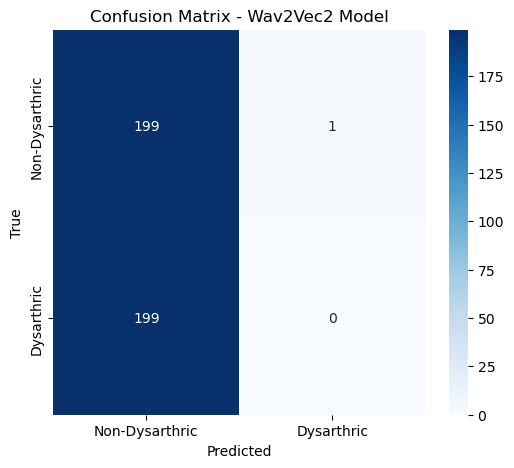

In [135]:
cm_wav2 = wav2vec_metrics['confusion_matrix']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_wav2, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Dysarthric', 'Dysarthric'], yticklabels=['Non-Dysarthric', 'Dysarthric'])
plt.title('Confusion Matrix - Wav2Vec2 Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

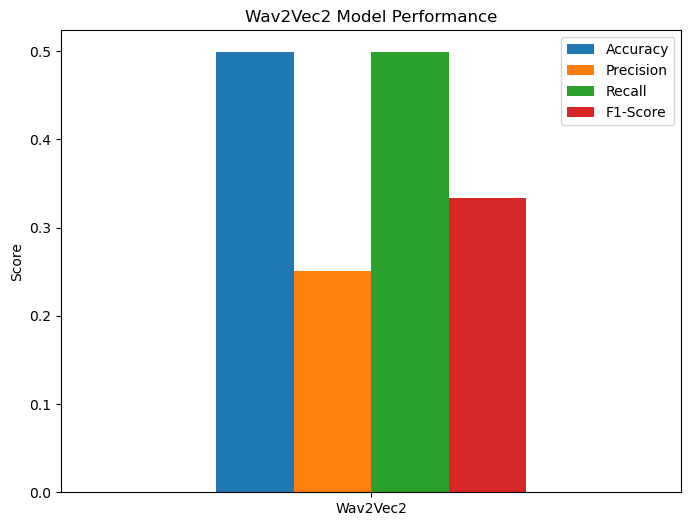

In [136]:
models = ['Wav2Vec2']
accuracies = [wav2vec_metrics['accuracy']]
precisions = [wav2vec_metrics['precision']]
recalls = [wav2vec_metrics['recall']]
f1_scores = [wav2vec_metrics['f1_score']]

# Plotting bar charts for model performance
metrics_df = pd.DataFrame({
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
}, index=models)

metrics_df.plot(kind='bar', figsize=(8, 6))
plt.title('Wav2Vec2 Model Performance')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()

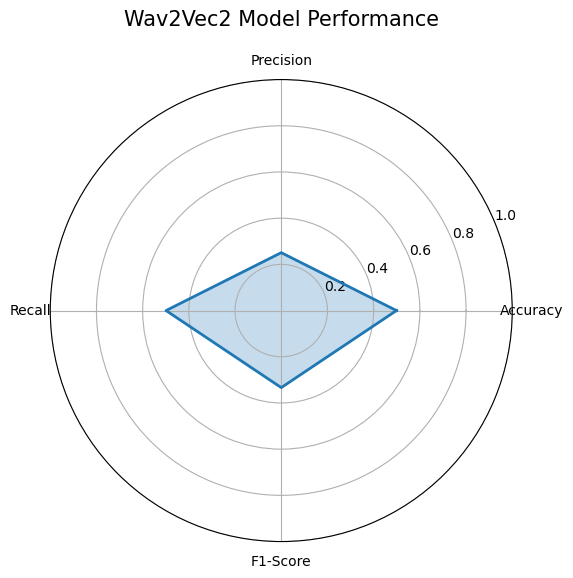

In [137]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [wav2vec_metrics['accuracy'], wav2vec_metrics['precision'], wav2vec_metrics['recall'], wav2vec_metrics['f1_score']]

# Normalize values between 0 and 1
values = [val for val in values]
values += values[:1]  # Close the loop

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Create a radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, label='Wav2Vec2', linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.25)

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title('Wav2Vec2 Model Performance', size=15, pad=20)
ax.set_ylim(0, 1)

plt.show()

### 3. Self Supervised Learning (HuBERT)

In [127]:
import logging

logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(levelname)s - %(message)s')

class HubertModel:
    def __init__(self):
        """
        Initialize the HuBERT model and feature extractor.
        """
        # Load feature extractor and model
        self.processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
        self.model = HubertForSequenceClassification.from_pretrained(
            "facebook/hubert-base-ls960",
            num_labels=2  # Binary classification: Non-Dysarthric (0), Dysarthric (1)
        )
        self.model.eval()  # Set the model to evaluation mode

    def preprocess(self, audio_path):
        """
        Preprocess the audio file for model inference.
        
        Args:
            audio_path (str): Path to the audio file.
        
        Returns:
            inputs (dict): Preprocessed inputs for the model.
        """
        # Preprocessing the audio
        audio_input, _ = librosa.load(audio_path, sr=16000)  # Ensure sampling rate is 16kHz
        inputs = self.processor(audio_input, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs

    def predict(self, inputs):
        """
        Perform inference on the given inputs.
        
        Args:
            inputs (dict): Preprocessed inputs for the model.
        
        Returns:
            torch.Tensor: Predicted label (0 or 1).
        """
        # Predicting the output
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
        return torch.argmax(logits, dim=-1)


# Function to evaluate the model
def evaluate_hubert_model(model, df_sampled):
    """
    Evaluate the HuBERT model on a given dataset.
    
    Args:
        model (HubertModel): Initialized HuBERT model instance.
        df_sampled (DataFrame): Dataset with 'path' (audio file path) and 'label' (true label).
    
    Returns:
        dict: Evaluation metrics including accuracy, precision, recall, F1-score, and confusion matrix.
    """
    true_labels = []
    predicted_labels = []

    # Iterate over the dataset
    for _, row in tqdm(df_sampled.iterrows(), total=len(df_sampled), desc="Processing files", unit="file"):
        sample_audio_path = row['path']
        true_labels.append(row['label'])
        try:
            # Preprocess and predict
            inputs = model.preprocess(sample_audio_path)
            prediction = model.predict(inputs)
            predicted_labels.append(prediction.item())
        except Exception as e:
            logging.error(f"Error processing file {sample_audio_path}: {e}")
            true_labels.pop()  # Remove the label if prediction fails

    # Calculate evaluation metrics
    evaluation_metrics = {
        'accuracy': accuracy_score(true_labels, predicted_labels),
        'confusion_matrix': confusion_matrix(true_labels, predicted_labels),
        'classification_report': classification_report(true_labels, predicted_labels, target_names=['Non-Dysarthric', 'Dysarthric']),
        'f1_score': f1_score(true_labels, predicted_labels, average='weighted'),
        'precision': precision_score(true_labels, predicted_labels, average='weighted'),
        'recall': recall_score(true_labels, predicted_labels, average='weighted')
    }

    # Display results
    print("\nClassification Report:\n", evaluation_metrics['classification_report'])
    print(f"\nTest Accuracy: {evaluation_metrics['accuracy']:.4f}\n")
    return evaluation_metrics


# Evaluate the HuBERT Model
hubert_model = HubertModel()

# Replace `df_sampled` with your actual dataset
hubert_metrics = evaluate_hubert_model(hubert_model, df_sampled)

# Store HuBERT metrics (if maintaining a dictionary for multiple models)
advanced_model_metrics = {}
advanced_model_metrics['HuBERT'] = hubert_metrics

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing files: 100%|██████████| 400/400 [06:34<00:00,  1.01file/s]


Classification Report:
                 precision    recall  f1-score   support

Non-Dysarthric       0.55      0.94      0.69       200
    Dysarthric       0.77      0.22      0.34       199

      accuracy                           0.58       399
     macro avg       0.66      0.58      0.51       399
  weighted avg       0.66      0.58      0.51       399


Test Accuracy: 0.5764



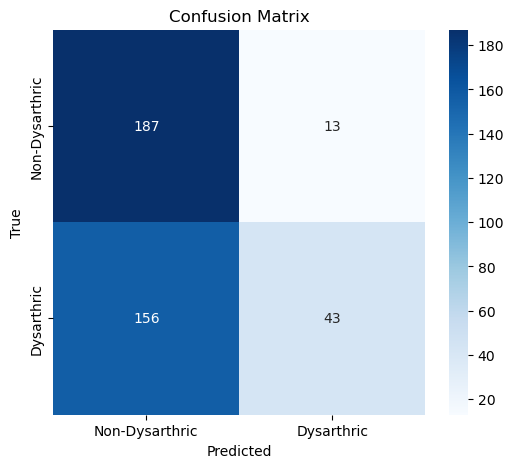

In [131]:
cm_hub = hubert_metrics['confusion_matrix']

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_hub, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Dysarthric', 'Dysarthric'], yticklabels=['Non-Dysarthric', 'Dysarthric'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

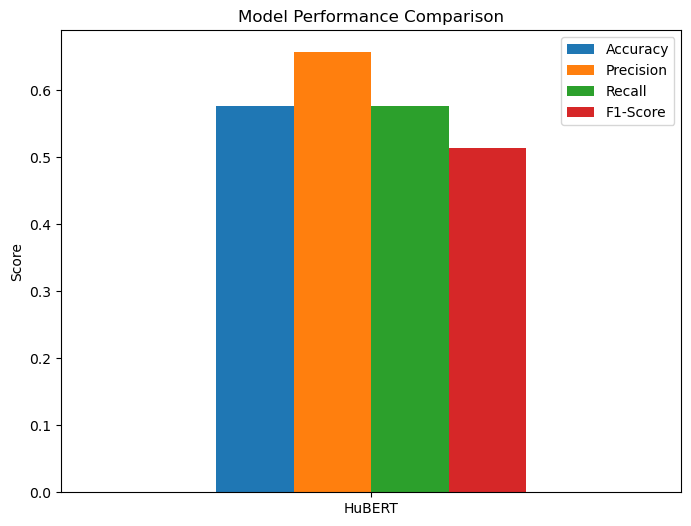

In [133]:
# Collecting the performance metrics
models = ['HuBERT']
accuracies = [hubert_metrics['accuracy']]
precisions = [hubert_metrics['precision']]
recalls = [hubert_metrics['recall']]
f1_scores = [hubert_metrics['f1_score']]

# Plotting bar charts
metrics_df = pd.DataFrame({
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores
}, index=models)

metrics_df.plot(kind='bar', figsize=(8, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.show()


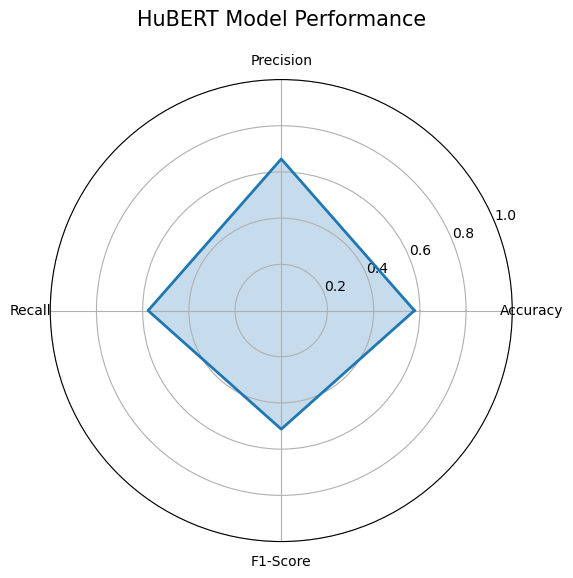

In [ ]:

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [hubert_metrics['accuracy'], hubert_metrics['precision'], hubert_metrics['recall'], hubert_metrics['f1_score']]

# Normalize values between 0 and 1
values = [val for val in values]
values += values[:1]  # Close the loop

angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Create a radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, label='HuBERT', linewidth=2, linestyle='solid')
ax.fill(angles, values, alpha=0.25)

# Add labels and title
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title('HuBERT Model Performance', size=15, pad=20)
ax.set_ylim(0, 1)

plt.show()
